--- BẮT ĐẦU VẼ TỔNG HỢP CHO BRUSSELS, BERLIN, PARIS ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


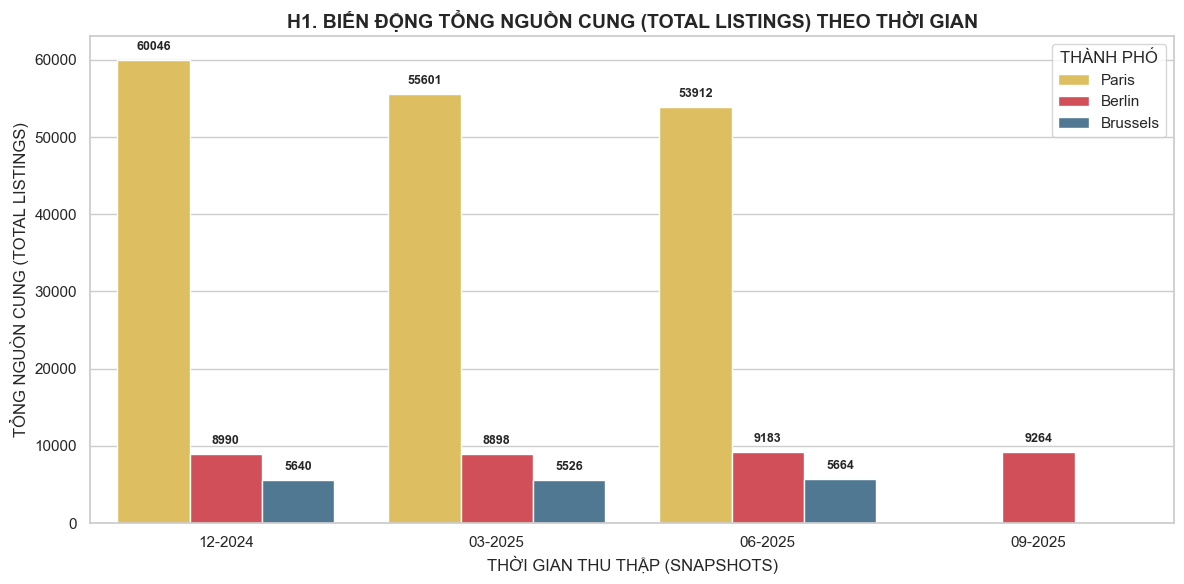

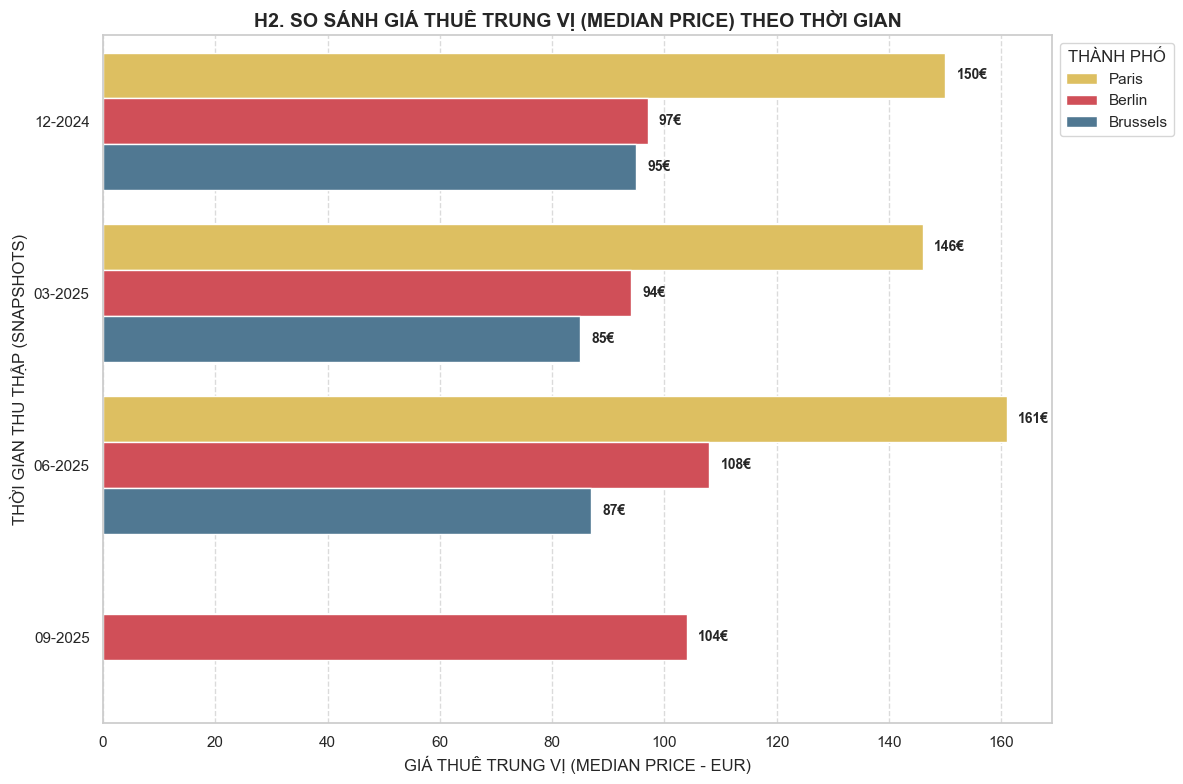

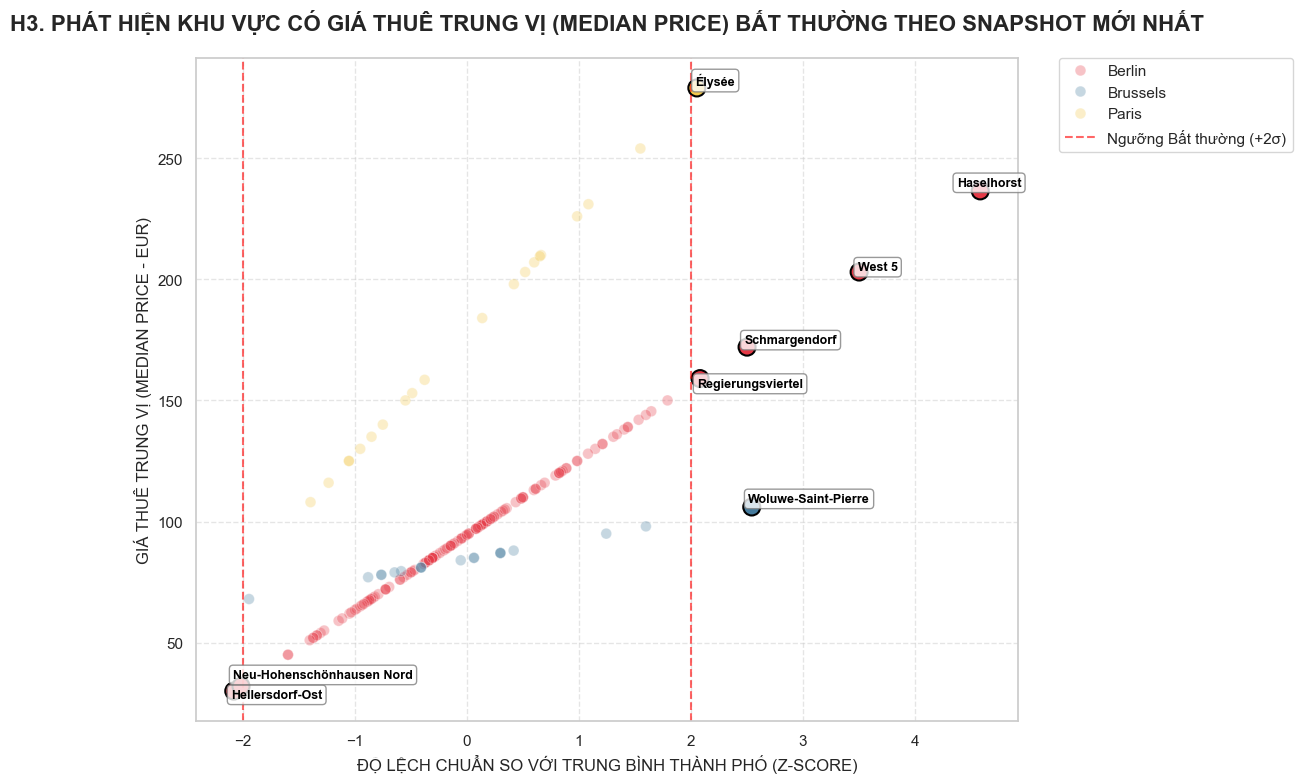

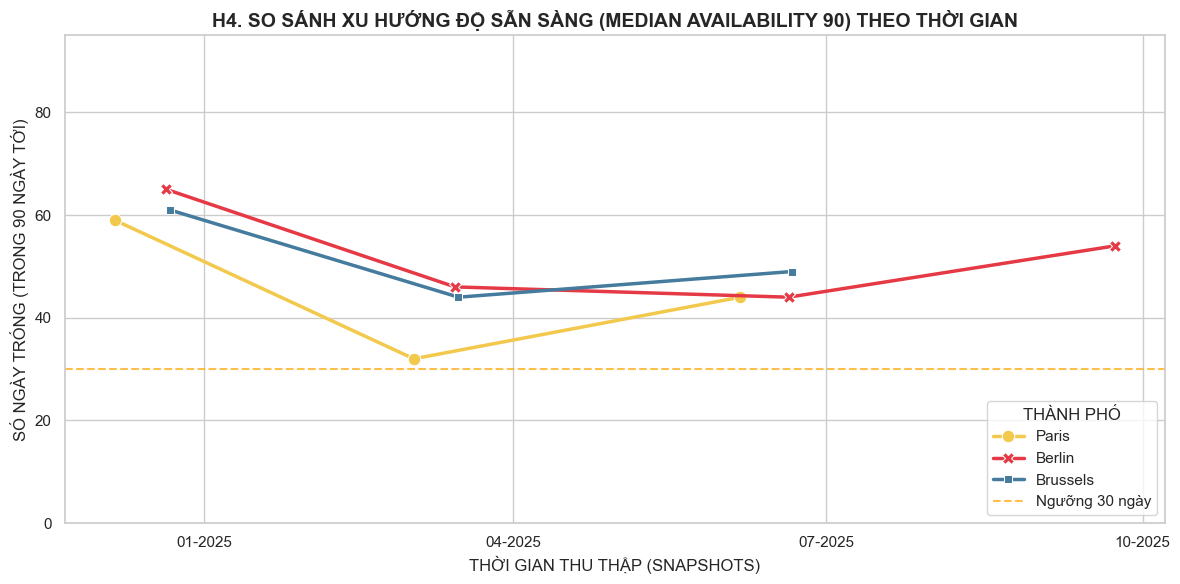

<Figure size 1000x700 with 0 Axes>

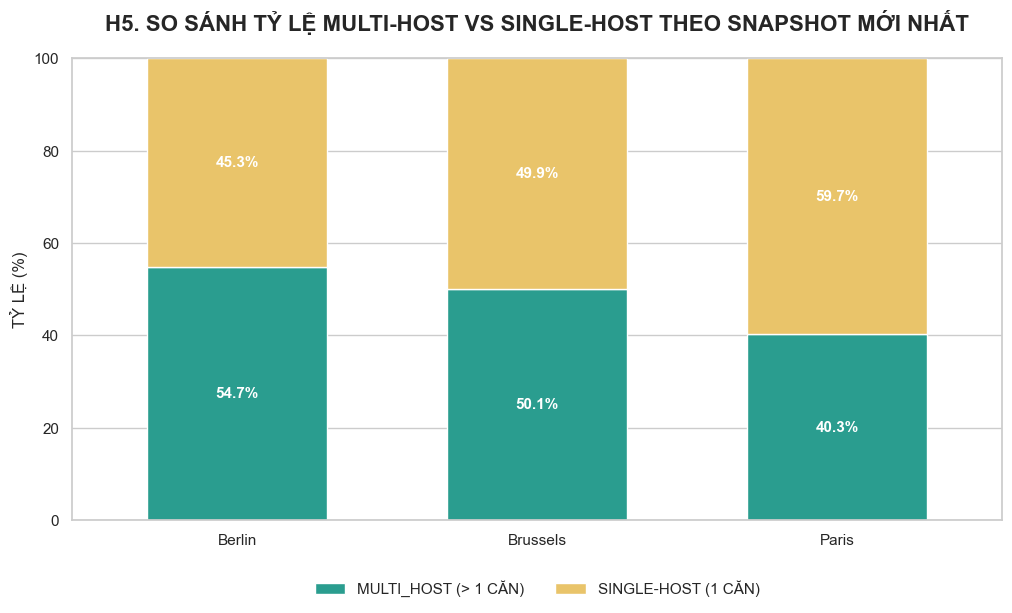

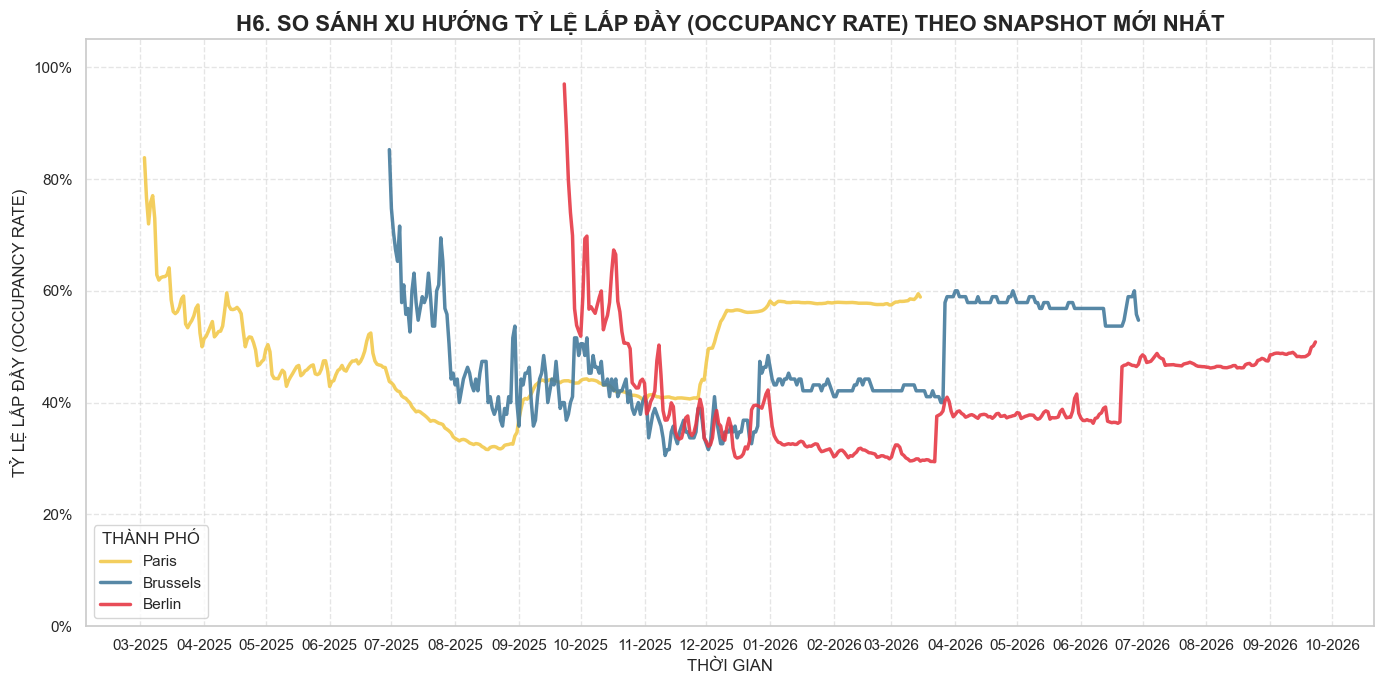

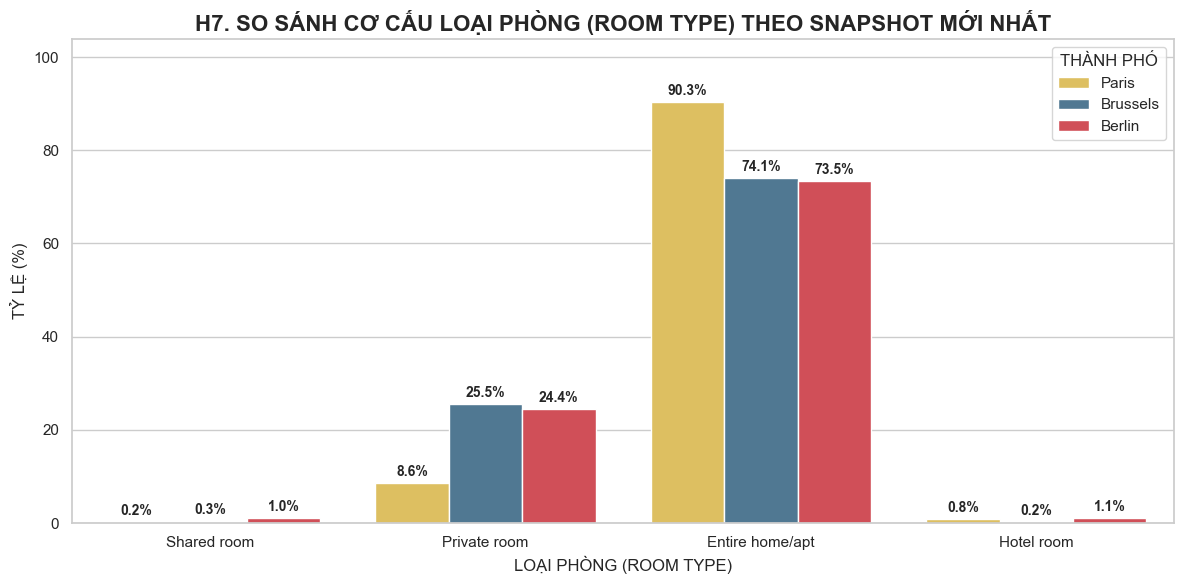

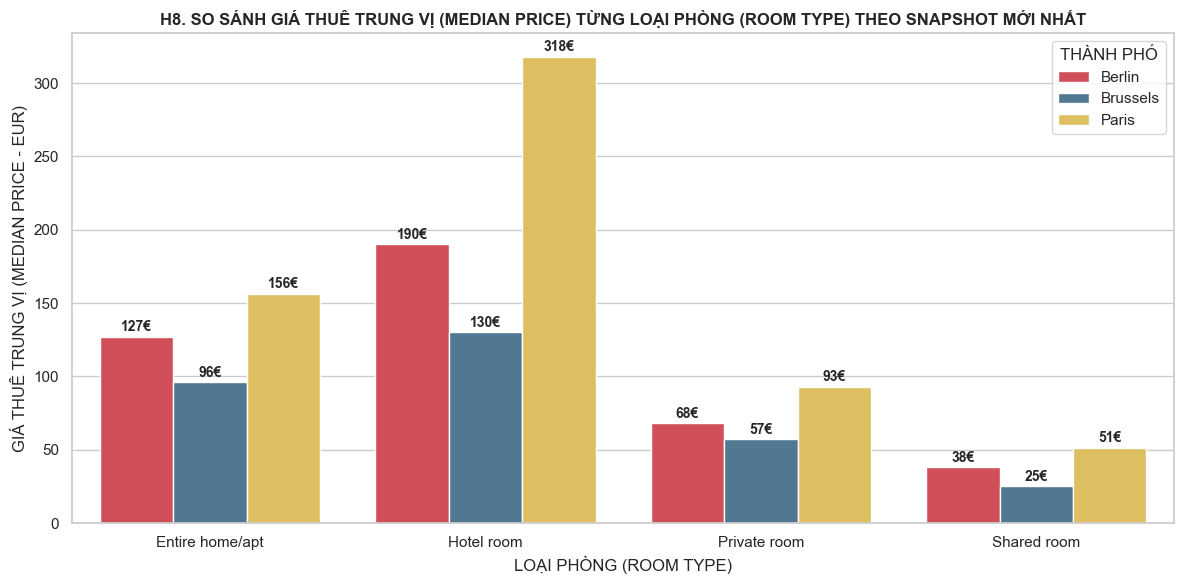

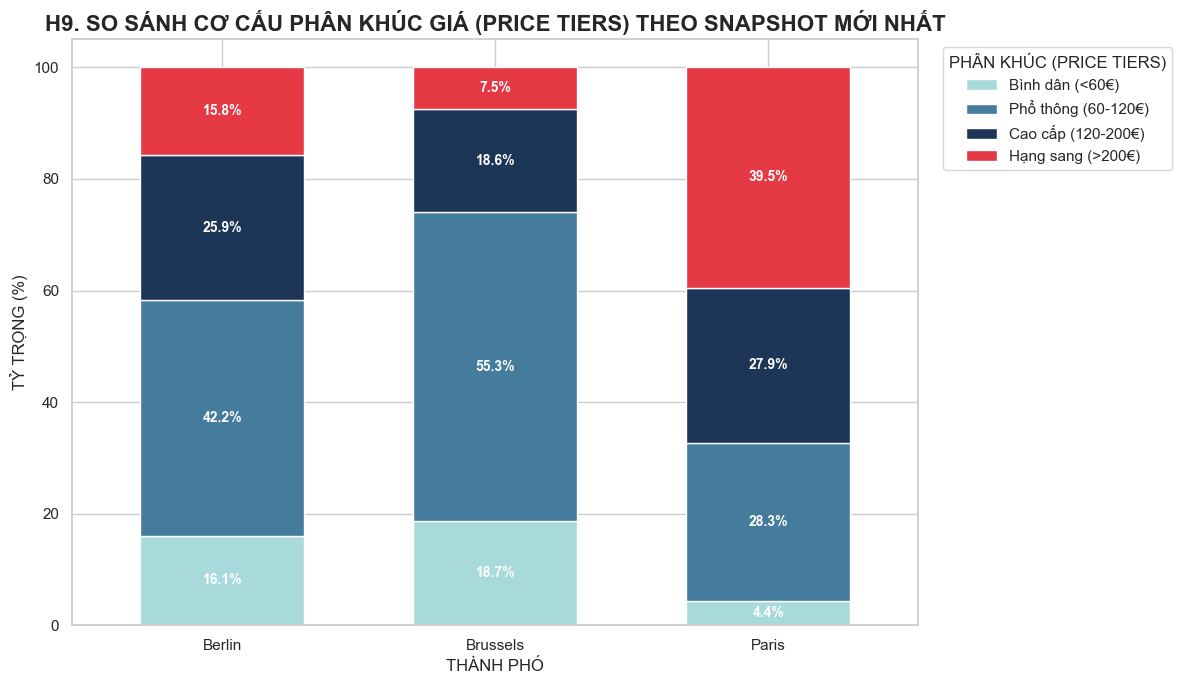

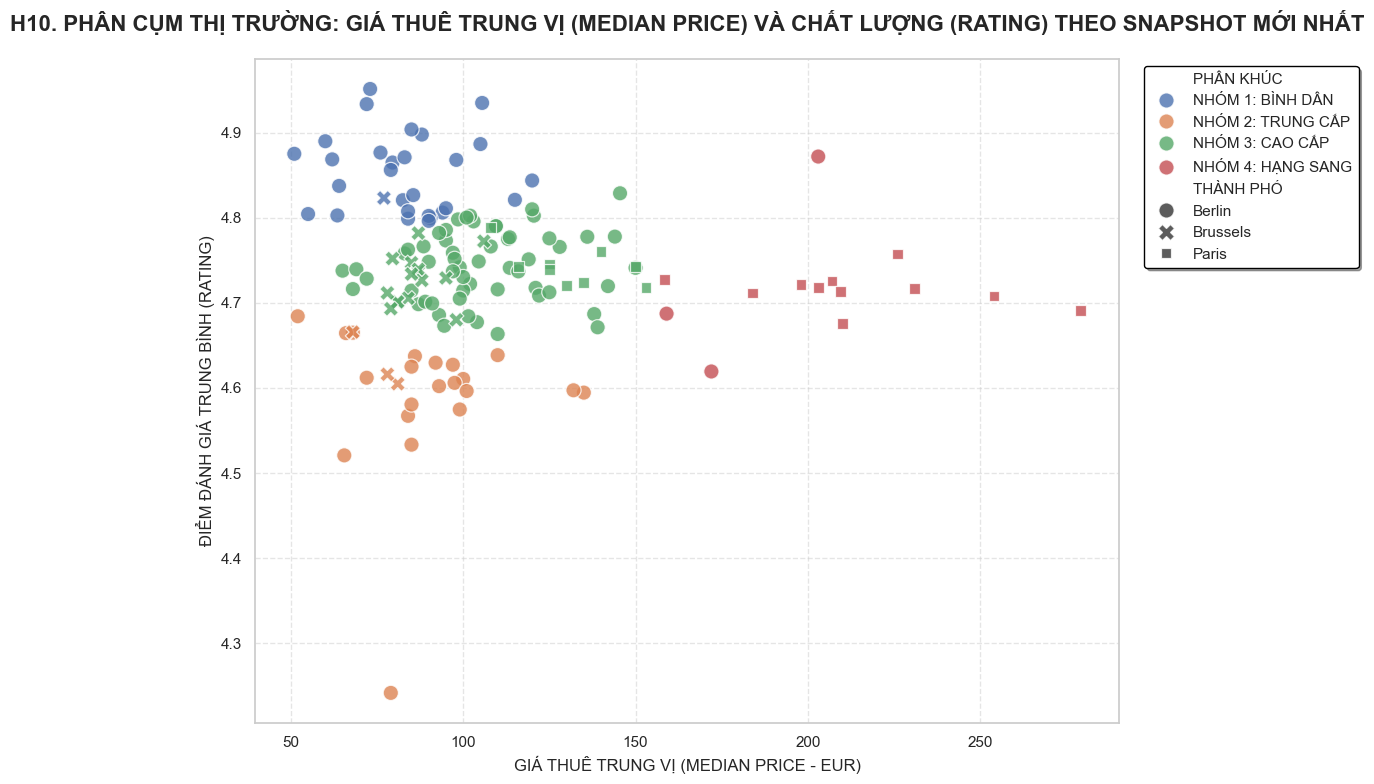

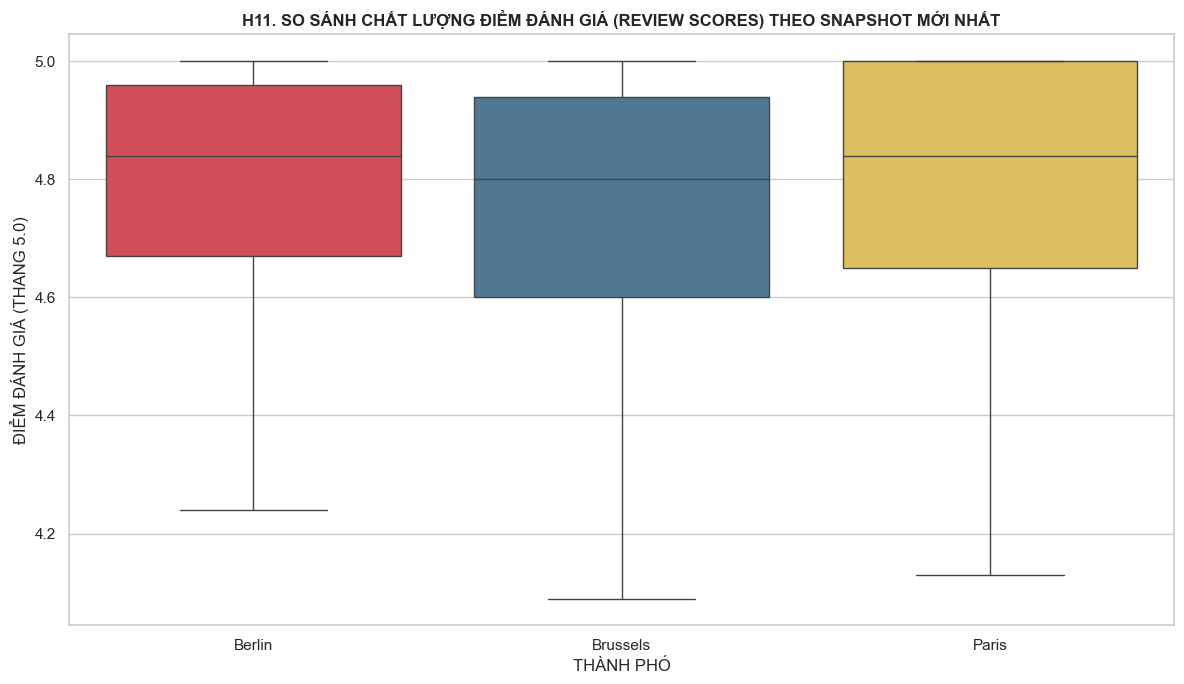

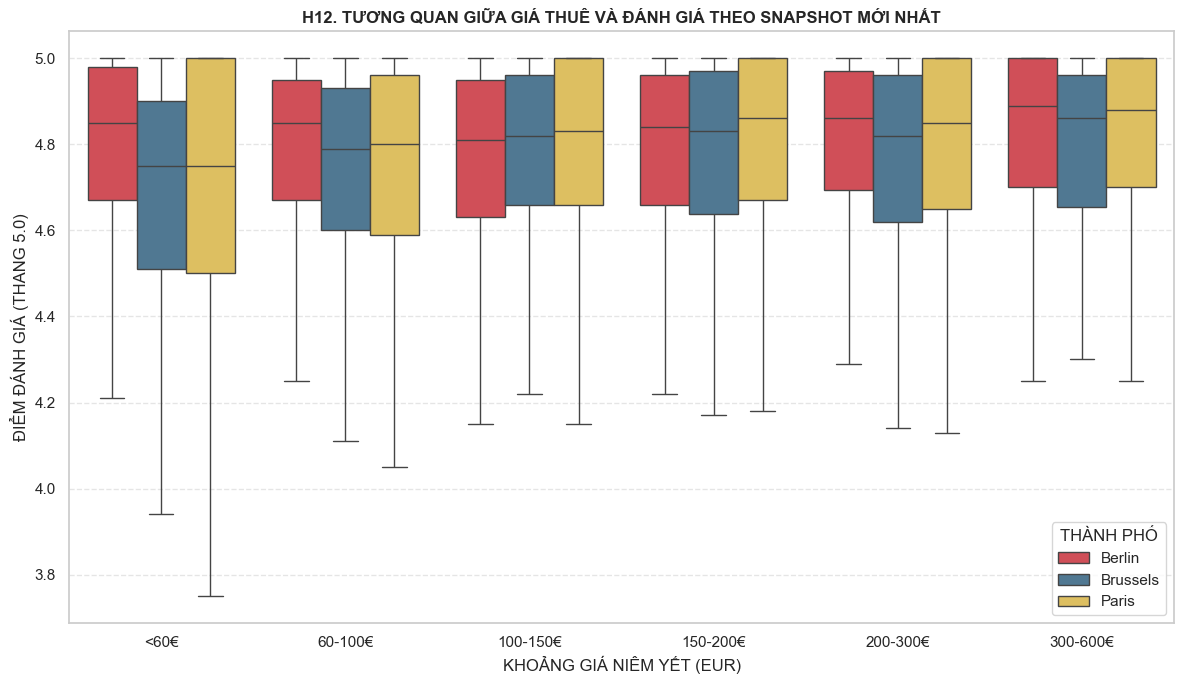

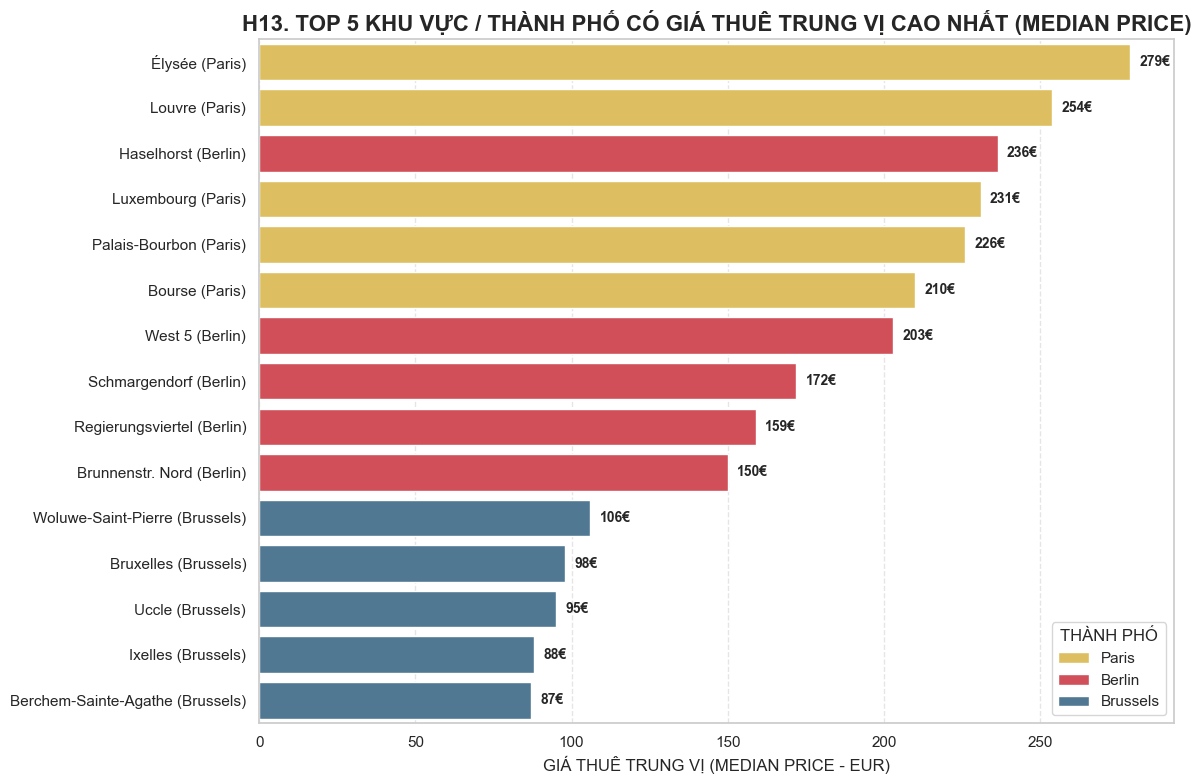

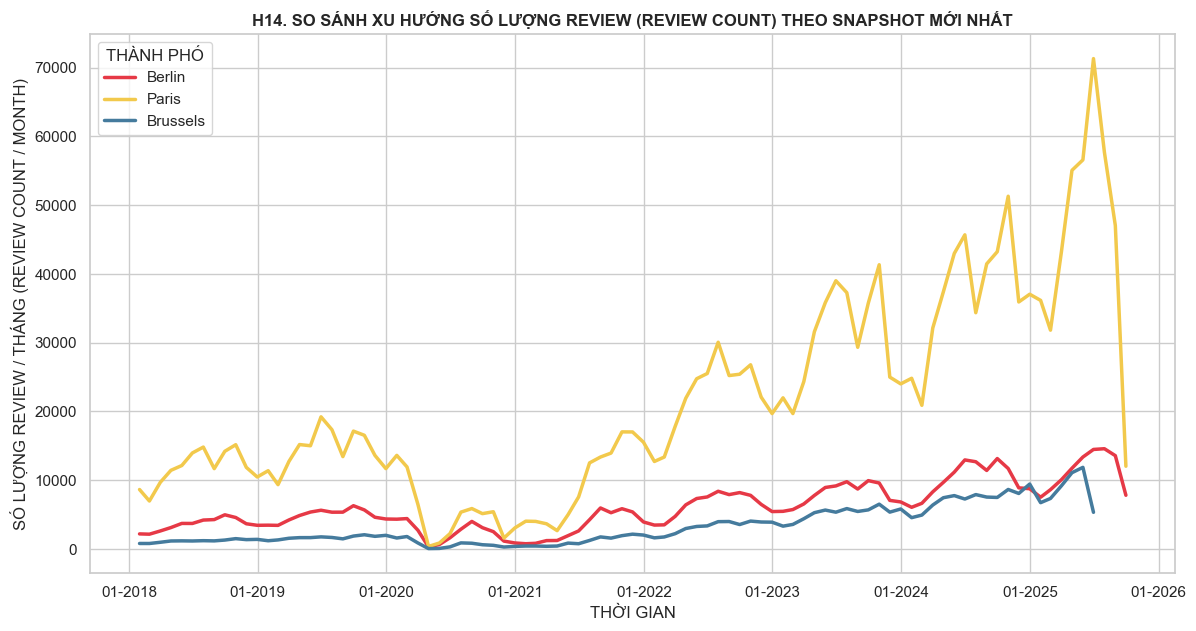

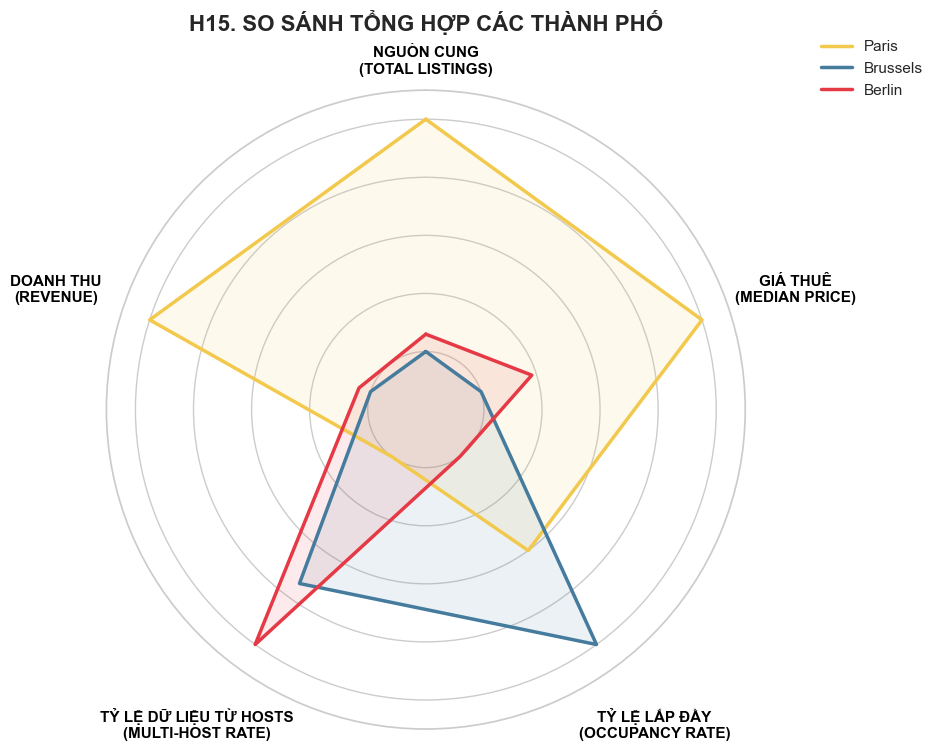

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from math import pi
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
!pip install adjustText


# ==============================================================================
# 0. CONFIG
# ==============================================================================
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 12})

CITY_COLORS = {
    'Berlin': '#E63946',
    'Brussels': '#457B9D',
    'Paris': '#F2C94C'
}

# ==============================================================================
# HELPERS
# ==============================================================================
def safe_capitalize_city(name):
    """Normalize city folder name -> Title case single token (Berlin, Brussels, Paris)."""
    if not isinstance(name, str): 
        return name
    name = name.strip()
    # if folder contains underscores or spaces, take first token (assumes structure processed/<city>/...)
    token = name.split(os.sep)[-1].split('_')[0].split()[0]
    return token.capitalize()

def parse_flexible_date(s):
    """Try several likely date formats, return pd.Timestamp or NaT."""
    if pd.isna(s): 
        return pd.NaT
    s = str(s).strip()
    formats = ["%d %B, %Y", "%d %B %Y", "%Y-%m-%d", "%d-%m-%Y", "%d %b, %Y", "%d %b %Y"]
    for fmt in formats:
        try:
            return pd.to_datetime(datetime.strptime(s, fmt))
        except Exception:
            continue
    # fallback to pandas parser
    try:
        return pd.to_datetime(s, dayfirst=True, errors='coerce')
    except:
        return pd.NaT

def load_kpi_data(pattern):
    """Load KPI files matching pattern under processed/*/<pattern> and append City column."""
    all_files = glob.glob(os.path.join(PROCESSED_DIR, '*', pattern))
    df_list = []
    for f in all_files:
        city_folder = os.path.basename(os.path.dirname(f))
        city = safe_capitalize_city(city_folder)
        try:
            df = pd.read_csv(f)
            df['City'] = city
            df_list.append(df)
        except Exception:
            continue
    return pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()

def load_latest_listing_for_city(city):
    """Return the most recent listings_processed.csv for a given city folder (by parsing snapshot folder names)."""
    city_path = os.path.join(PROCESSED_DIR, city.lower())
    if not os.path.exists(city_path):
        # try capitalized
        city_path = os.path.join(PROCESSED_DIR, city)
        if not os.path.exists(city_path):
            return pd.DataFrame()
    # get folders
    folders = [d for d in os.listdir(city_path) if os.path.isdir(os.path.join(city_path, d))]
    # parse dates
    folder_dates = []
    for f in folders:
        dt = parse_flexible_date(f)
        if not pd.isna(dt):
            folder_dates.append((f, dt))
    if not folder_dates:
        return pd.DataFrame()
    # sort by date desc and pick first valid file
    folder_dates = sorted(folder_dates, key=lambda x: x[1], reverse=True)
    for f, _ in folder_dates:
        fp = os.path.join(city_path, f, 'listings_processed.csv')
        if os.path.exists(fp):
            try:
                df = pd.read_csv(fp, low_memory=False)
                if not df.empty and 'price_numeric' in df.columns and df['price_numeric'].notna().sum() > 0:
                    df['City'] = safe_capitalize_city(city)
                    return df
            except Exception:
                continue
    return pd.DataFrame()

# ==============================================================================
# LOAD RAW LISTINGS LATEST PER CITY 
# ==============================================================================
cities_list = ['berlin', 'brussels', 'paris']
df_listings_all = []
for city in cities_list:
    df_city = load_latest_listing_for_city(city)
    if not df_city.empty:
        df_listings_all.append(df_city)
df_detail = pd.concat(df_listings_all, ignore_index=True) if df_listings_all else pd.DataFrame()

# ==============================================================================
# LOAD KPI SUMMARY / ROOM / SEASONALITY
# ==============================================================================
print("--- BẮT ĐẦU VẼ TỔNG HỢP CHO BRUSSELS, BERLIN, PARIS ---")
print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
df_summary = load_kpi_data('kpi_summary_general_*.csv')
df_room = load_kpi_data('kpi_room_type_*.csv')
df_season = load_kpi_data('kpi_seasonality_*.csv')
df_neigh_kpi = load_kpi_data('kpi_neighbourhood_*.csv')
df_review_kpi = load_kpi_data('kpi_reviews_trend_*.csv')

# Clean summary
if not df_summary.empty:
    # ensure numeric where expected
    for col in ['total_listings', 'median_price', 'median_avail_90', 'multi_host_rate']:
        if col in df_summary.columns:
            df_summary[col] = pd.to_numeric(df_summary[col], errors='coerce')
    df_clean_sum = df_summary[(df_summary['total_listings'].fillna(0) > 0) & (df_summary.get('median_price').notna())].copy()
    df_clean_sum['snapshot_dt'] = df_clean_sum['snapshot_date'].apply(parse_flexible_date)
    df_clean_sum = df_clean_sum.dropna(subset=['snapshot_dt'])
    valid_keys = set(zip(df_clean_sum['City'], df_clean_sum['snapshot_date']))
else:
    print("⚠️ Không có dữ liệu summary!")
    df_clean_sum = pd.DataFrame()
    valid_keys = set()

# ==============================================================================
# PLOTS H1-H6
# ==============================================================================

# H1: Total listings (bar by snapshot month-year, grouped by city)
if not df_summary.empty:
    df_h1 = df_summary.copy()
    df_h1['snapshot_dt'] = df_h1['snapshot_date'].apply(parse_flexible_date)
    df_h1 = df_h1.dropna(subset=['snapshot_dt'])
    df_h1['Period'] = df_h1['snapshot_dt'].dt.strftime('%m-%Y')
    df_h1 = df_h1.sort_values('snapshot_dt')

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df_h1, x='Period', y='total_listings', hue='City', palette=CITY_COLORS)
    for p in ax.patches:
        h = p.get_height()
        if h and h > 0:
            ax.annotate(f'{int(h)}', (p.get_x() + p.get_width() / 2., h),
                        ha='center', va='bottom', xytext=(0, 5), textcoords='offset points',
                        fontsize=9, fontweight='bold')
    plt.title('H1. BIẾN ĐỘNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.legend(title='THÀNH PHỐ', loc='upper right')
    save_path = os.path.join(FIGURES_DIR, 'H01_Total_Supply_All_Snapshots.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()
    

# H2: Median price (horizontal)
if not df_clean_sum.empty:
    df_h2 = df_clean_sum.copy()
    df_h2 = df_h2.sort_values('snapshot_dt')
    df_h2['Period'] = df_h2['snapshot_dt'].dt.strftime('%m-%Y')

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_h2, x='median_price', y='Period', hue='City', palette=CITY_COLORS, orient='h')

    for p in ax.patches:
        width = p.get_width()
        if width and width > 0:
            ax.text(width + 2, p.get_y() + p.get_height() / 2, f'{int(width)}€',
                    ha='left', va='center', fontsize=10, fontweight='bold')
    plt.title('H2. SO SÁNH GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.legend(title='THÀNH PHỐ', bbox_to_anchor=(1, 1))
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    save_path = os.path.join(FIGURES_DIR, 'H02_Median_Price_Horizontal.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()


# H3: Z-SCORE
# Giả định các biến môi trường đã có:
# df_detail, FIGURES_DIR, CITY_COLORS

if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns:
    # 1. Chuẩn bị dữ liệu
    df_anom = df_detail.copy()
    
    # Chuyển đổi số và loại bỏ lỗi
    df_anom['price_numeric'] = pd.to_numeric(df_anom['price_numeric'], errors='coerce')
    df_anom = df_anom.dropna(subset=['price_numeric', 'neighbourhood_cleansed'])

    # 2. Aggregation: Tính giá trung vị cho từng khu vực
    neigh_price = (
        df_anom
        .groupby(['City', 'neighbourhood_cleansed'])['price_numeric']
        .median()
        .reset_index()
    )

    # Lọc bỏ các thành phố có ít hơn 3 khu vực (để tính std có ý nghĩa)
    city_counts = neigh_price['City'].value_counts()
    valid_cities = city_counts[city_counts > 2].index
    neigh_price = neigh_price[neigh_price['City'].isin(valid_cities)].copy()

    # 3. Tính Z-score per city
    # Sử dụng ddof=1 cho độ lệch chuẩn mẫu (sample std dev)
    # Xử lý trường hợp std = 0 bằng cách thay thế kết quả NaN/Inf bằng 0
    def calculate_zscore(x):
        std = x.std(ddof=1)
        if std == 0:
            return np.zeros_like(x)
        return (x - x.mean()) / std

    neigh_price['z_score'] = neigh_price.groupby('City')['price_numeric'] \
        .transform(calculate_zscore)

    # Lọc Anomaly
    anomalies = neigh_price[neigh_price['z_score'].abs() >= 2]

    # 4. Vẽ biểu đồ
    plt.figure(figsize=(12, 8)) # Tăng chiều cao một chút
    
    # Layer 1: Tất cả các điểm (Mờ)
    sns.scatterplot(
        data=neigh_price,
        x='z_score',
        y='price_numeric',
        hue='City',
        palette=CITY_COLORS,
        alpha=0.3, # Giảm alpha để làm nổi bật anomalies hơn
        s=60,
        legend=True # Giữ legend ở đây
    )

    # Layer 2: Chỉ các điểm bất thường (Nổi bật)
    sns.scatterplot(
        data=anomalies,
        x='z_score',
        y='price_numeric',
        hue='City',
        palette=CITY_COLORS,
        s=150,
        legend=False,
        edgecolor='black',
        linewidth=1.5,
        marker='o' # Đảm bảo hình dạng rõ ràng
    )

    # Layer 3: Annotations (Nhãn)
    texts = []
    for i, row in anomalies.iterrows():
    # SỬA Ở ĐÂY: Dùng hàm abs() để lấy cả 2 bên (lớn hơn 2 hoặc nhỏ hơn -2)
        if abs(row['z_score']) >= 2: 
            texts.append(plt.text(
            row['z_score'], 
            row['price_numeric'], 
            row['neighbourhood_cleansed'], 
            fontsize=9, 
            color='black', 
            weight='bold',
            # Thêm alpha=0.8 để nền trắng che bớt các điểm phía sau cho dễ đọc
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.3')
        ))

    # Cố gắng sử dụng adjust_text để chống đè chữ (nếu thư viện có sẵn)
    try:
        from adjustText import adjust_text
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    except ImportError:
        pass # Nếu không có thư viện thì giữ nguyên vị trí mặc định

    # Lines & Decor
    plt.axvline(2, color='red', linestyle='--', alpha=0.6, label='Ngưỡng Bất thường (+2σ)')
    plt.axvline(-2, color='red', linestyle='--', alpha=0.6)

    plt.title('H3. PHÁT HIỆN KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) BẤT THƯỜNG THEO SNAPSHOT MỚI NHẤT', 
              fontweight='bold', fontsize=16, pad=20)
    plt.xlabel('ĐỘ LỆCH CHUẨN SO VỚI TRUNG BÌNH THÀNH PHỐ (Z-SCORE)')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    
    # Xử lý Legend để không bị trùng lặp
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Lưu và hiển thị
    if not os.path.exists(FIGURES_DIR):
        os.makedirs(FIGURES_DIR)
    plt.savefig(os.path.join(FIGURES_DIR, 'H03_Price_Anomaly_ZScore.pdf'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Dữ liệu không đủ hoặc thiếu cột cần thiết.")




# H4: Availability trend (median_avail_90)
if not df_clean_sum.empty and 'median_avail_90' in df_clean_sum.columns:
    df_h3 = df_clean_sum[df_clean_sum['median_avail_90'].notna()].copy()
    df_h3 = df_h3.sort_values('snapshot_dt')
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_h3, x='snapshot_dt', y='median_avail_90', hue='City', palette=CITY_COLORS,
                 style='City', markers=True, dashes=False, linewidth=2.5, markersize=9)
    plt.axhline(30, color='orange', linestyle='--', alpha=0.7, label='Ngưỡng 30 ngày')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.title('H4. SO SÁNH XU HƯỚNG ĐỘ SẴN SÀNG (MEDIAN AVAILABILITY 90) THEO THỜI GIAN', fontweight='bold', fontsize=14)
    plt.ylabel('SỐ NGÀY TRỐNG (TRONG 90 NGÀY TỚI)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylim(0, 95)
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    save_path = os.path.join(FIGURES_DIR, 'H04_Availability_Trend.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()






# H5: Multi-host stacked bar (latest snapshot per city)
if not df_clean_sum.empty and 'multi_host_rate' in df_clean_sum.columns:
    df_latest = df_clean_sum.sort_values('snapshot_dt').groupby('City').tail(1).copy()
    df_latest['single_host_rate'] = 100 - df_latest['multi_host_rate']
    plot_data = df_latest.set_index('City')[['multi_host_rate', 'single_host_rate']]
    plot_data = plot_data.sort_values('multi_host_rate', ascending=False)
    plt.figure(figsize=(10, 7))
    ax = plot_data.plot(kind='bar', stacked=True, color=['#2A9D8F', '#E9C46A'], width=0.6, rot=0)
    for c in ax.containers:
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=11, fontweight='bold', color='white')
    plt.title('H5. SO SÁNH TỶ LỆ MULTI-HOST VS SINGLE-HOST THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16, pad=20)
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('')
    plt.ylim(0, 100)
    plt.legend(['MULTI_HOST (> 1 CĂN)', 'SINGLE-HOST (1 CĂN)'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)
    save_path = os.path.join(FIGURES_DIR, 'H05_MultiHost_Stacked.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight', pad_inches=0.5)
    plt.show()
    

# H6: Occupancy rate - plot daily series for latest snapshot per city
if not df_season.empty and 'date' in df_season.columns and 'occupancy_rate' in df_season.columns:
    df_h5 = df_season.copy()
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = df_h5['snapshot_date'].apply(parse_flexible_date)
    df_h5 = df_h5.dropna(subset=['snapshot_dt'])
    latest_snaps = df_h5.groupby('City')['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5.apply(lambda r: r['snapshot_dt'] == latest_snaps.get(r['City'], pd.NaT), axis=1)]
    df_final_h5 = df_final_h5.sort_values('date_dt')
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', hue='City', palette=CITY_COLORS, linewidth=2.5, alpha=0.9)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.title('H6. SO SÁNH XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16)
    plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
    plt.xlabel('THỜI GIAN')
    plt.legend(title='THÀNH PHỐ', loc='lower left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(0, 1.05)
    save_path = os.path.join(FIGURES_DIR, 'H06_Occupancy_Rate_LineChart.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()
    

# H7: Room type composition (latest snapshot)
if not df_room.empty and not df_clean_sum.empty:
    
    df_room = df_room.copy()
    df_room['key'] = list(zip(df_room['City'], df_room['snapshot_date']))
    df_room_clean = df_room[df_room['key'].isin(valid_keys)].copy()
    df_room_clean['snapshot_dt'] = df_room_clean['snapshot_date'].apply(parse_flexible_date)
    latest_room = df_room_clean.sort_values('snapshot_dt').groupby(['City', 'room_type']).tail(1)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=latest_room, x='room_type', y='percentage', hue='City', palette=CITY_COLORS)
    for p in ax.patches:
        height = p.get_height()
        if height and height > 0:
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', xytext=(0, 3), textcoords='offset points', fontweight='bold', fontsize=10)
    plt.title('H7. SO SÁNH CƠ CẤU LOẠI PHÒNG (ROOM TYPE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16)
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('LOẠI PHÒNG (ROOM TYPE)')
    plt.legend(title='THÀNH PHỐ')
    if not latest_room['percentage'].empty:
        plt.ylim(0, latest_room['percentage'].max() * 1.15)
    save_path = os.path.join(FIGURES_DIR, 'H07_Room_Type_GroupedBar.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()




# H8: Price by Room Type (Grouped Bar)
if not df_detail.empty and 'review_scores_rating' in df_detail.columns:
    df_clean = df_detail.copy()
    df_clean['review_scores_rating'] = pd.to_numeric(df_clean['review_scores_rating'], errors='coerce')
    df_clean['price_numeric'] = pd.to_numeric(df_clean['price_numeric'], errors='coerce')
    df_clean = df_clean.dropna(subset=['review_scores_rating', 'price_numeric', 'room_type'])
    price_room = df_clean.groupby(['City', 'room_type'])['price_numeric'].median().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=price_room, x='room_type', y='price_numeric', 
                hue='City', palette=CITY_COLORS)
    plt.title('H8. SO SÁNH GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) TỪNG LOẠI PHÒNG (ROOM TYPE) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.xlabel('LOẠI PHÒNG (ROOM TYPE)')
    plt.legend(title = 'THÀNH PHỐ', loc = 'upper right')
    ax = plt.gca()
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{int(p.get_height())}€', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, fontweight='bold', xytext=(0, 2), textcoords='offset points')

    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H08_Price_RoomType.pdf'))
    plt.show()
    



# H9: Price segments stacked bar
if not df_detail.empty and 'price_numeric' in df_detail.columns:
    bins = [0, 60, 120, 200, 99999]
    labels = ['Bình dân (<60€)', 'Phổ thông (60-120€)', 'Cao cấp (120-200€)', 'Hạng sang (>200€)']
    df_detail['price_numeric'] = pd.to_numeric(df_detail['price_numeric'], errors='coerce')
    df_detail = df_detail.dropna(subset=['price_numeric'])
    df_detail['Price_Tier'] = pd.cut(df_detail['price_numeric'], bins=bins, labels=labels, right=False)
    tier_counts = df_detail.groupby(['City', 'Price_Tier'], observed=True).size().reset_index(name='count')
    total_counts = df_detail.groupby('City')['price_numeric'].count().reset_index(name='total')
    tier_data = tier_counts.merge(total_counts, on='City')
    tier_data['percentage'] = (tier_data['count'] / tier_data['total']) * 100
    pivot_tier = tier_data.pivot(index='City', columns='Price_Tier', values='percentage').fillna(0)
    colors = ['#A8DADC', '#457B9D', '#1D3557', '#E63946']
    ax = pivot_tier.plot(kind='bar', stacked=True, figsize=(12, 7), color=colors, rot=0, width=0.6)
    for c in ax.containers:
        labels_text = [f'{v.get_height():.1f}%' if v.get_height() > 3 else '' for v in c]
        ax.bar_label(c, labels=labels_text, label_type='center', color='white', fontweight='bold', fontsize=10)
    plt.title('H9. SO SÁNH CƠ CẤU PHÂN KHÚC GIÁ (PRICE TIERS) THEO SNAPSHOT MỚI NHẤT', fontweight='bold', fontsize=16)
    plt.xlabel('THÀNH PHỐ')
    plt.ylabel('TỶ TRỌNG (%)')
    plt.legend(title='PHÂN KHÚC (PRICE TIERS)', bbox_to_anchor=(1.02, 1), loc='upper left')
    save_path = os.path.join(FIGURES_DIR, 'H09_Price_Segments.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.show()


# H10: K-MEANS
# 1. Chuẩn bị dữ liệu
if not df_detail.empty and 'review_scores_rating' in df_detail.columns:
    df_cluster = df_detail.copy()
    df_cluster['price_numeric'] = pd.to_numeric(df_cluster['price_numeric'], errors='coerce')
    df_cluster['review_scores_rating'] = pd.to_numeric(df_cluster['review_scores_rating'], errors='coerce')
    
    # Gom nhóm theo khu vực
    neigh_stats = df_cluster.groupby(['City', 'neighbourhood_cleansed']).agg({
        'price_numeric': 'median',
        'review_scores_rating': 'mean',
        'id': 'count'
    }).reset_index()
    
    # Lọc các khu vực quá nhỏ (< 10 listings) để tránh nhiễu
    neigh_stats = neigh_stats[neigh_stats['id'] > 10].dropna()

    # 2. Scaling & K-Means
    features = ['price_numeric', 'review_scores_rating']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(neigh_stats[features])

    k = 4 
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    neigh_stats['cluster_raw'] = kmeans.fit_predict(X_scaled)

    # Tính giá trung bình của từng cụm để sắp xếp từ Rẻ -> Đắt
    cluster_avg_price = neigh_stats.groupby('cluster_raw')['price_numeric'].mean().sort_values()
    
    reorder_map = {old_label: i for i, old_label in enumerate(cluster_avg_price.index)}
    
    neigh_stats['cluster_ordered'] = neigh_stats['cluster_raw'].map(reorder_map)
    
    labels_name = {
        0: 'NHÓM 1: BÌNH DÂN',
        1: 'NHÓM 2: TRUNG CẤP',
        2: 'NHÓM 3: CAO CẤP',
        3: 'NHÓM 4: HẠNG SANG'
    }
    neigh_stats['Segment'] = neigh_stats['cluster_ordered'].map(labels_name)
    neigh_stats = neigh_stats.rename(columns={
        'Segment': 'PHÂN KHÚC',
        'City': 'THÀNH PHỐ'
    })

    order_list = [
        'NHÓM 1: BÌNH DÂN', 
        'NHÓM 2: TRUNG CẤP', 
        'NHÓM 3: CAO CẤP', 
        'NHÓM 4: HẠNG SANG'
    ]

    plt.figure(figsize=(12, 8))
    
    sns.scatterplot(
        data=neigh_stats,
        x='price_numeric',
        y='review_scores_rating',
        hue='PHÂN KHÚC',     
        style='THÀNH PHỐ',   
        palette='deep',      
        s=120,               
        alpha=0.8,
        edgecolor='w',
        hue_order=order_list        
    )
    
    centers = scaler.inverse_transform(kmeans.cluster_centers_)

    plt.title('H10. PHÂN CỤM THỊ TRƯỜNG: GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) VÀ CHẤT LƯỢNG (RATING) THEO SNAPSHOT MỚI NHẤT', 
              fontweight='bold', fontsize=16, pad=20)
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('ĐIỂM ĐÁNH GIÁ TRUNG BÌNH (RATING)')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, edgecolor = 'black', facecolor = 'white', framealpha = 1, fancybox = True, shadow = True)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H10_KMeans_Price_Quality.pdf'), bbox_inches='tight')
    plt.show()


    # H11: Quality Comparison (Boxplot)
    # -------------------------------------------------------
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_clean, x='City', y='review_scores_rating', 
                hue='City', palette=CITY_COLORS, showfliers=False, legend=False)
    plt.title('H11. SO SÁNH CHẤT LƯỢNG ĐIỂM ĐÁNH GIÁ (REVIEW SCORES) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.xlabel('THÀNH PHỐ')
    plt.ylabel('ĐIỂM ĐÁNH GIÁ (THANG 5.0)')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H11_Quality_Scores.pdf'))
    plt.show()

    # H12: COMPARE PRICE AND REVIEWS
    plt.figure(figsize=(12, 7))
    price_bins = [0, 60, 100, 150, 200, 300, 600]
    bin_labels = ['<60€', '60-100€', '100-150€', '150-200€', '200-300€', '300-600€']
    df_clean.loc[:, 'price_range_group'] = pd.cut(df_clean['price_numeric'], bins=price_bins, labels=bin_labels)
    sns.boxplot(data=df_clean, x='price_range_group', y='review_scores_rating', 
                hue='City', palette=CITY_COLORS, showfliers=False) 
    
    plt.title('H12. TƯƠNG QUAN GIỮA GIÁ THUÊ VÀ ĐÁNH GIÁ THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.xlabel('KHOẢNG GIÁ NIÊM YẾT (EUR)')
    plt.ylabel('ĐIỂM ĐÁNH GIÁ (THANG 5.0)')
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'H12_Price_Quality_Boxplot.pdf'))
    plt.show()
    

# H13: Top neighborhoods by median price (top 5 per city)
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns and 'price_numeric' in df_detail.columns:
    df_detail = df_detail[df_detail['neighbourhood_cleansed'].notna()].copy()
    neigh_stats = df_detail.groupby(['City', 'neighbourhood_cleansed'], observed=True)['price_numeric'].median().reset_index()
    top_neighs = neigh_stats.sort_values(['City', 'price_numeric'], ascending=[True, False]).groupby('City').head(5)
    top_neighs = top_neighs.sort_values('price_numeric', ascending=False)
    top_neighs['Label'] = top_neighs['neighbourhood_cleansed'] + " (" + top_neighs['City'] + ")"

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=top_neighs, x='price_numeric', y='Label', hue='City', palette=CITY_COLORS, dodge=False)
    for p in ax.patches:
        width = p.get_width()
        if width and width > 0:
            ax.text(width + 3, p.get_y() + p.get_height() / 2, f'{int(width)}€', va='center', fontweight='bold', fontsize=10)
    plt.title('H13. TOP 5 KHU VỰC / THÀNH PHỐ CÓ GIÁ THUÊ TRUNG VỊ CAO NHẤT (MEDIAN PRICE)', fontweight='bold', fontsize=16)
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('')
    plt.legend(title='THÀNH PHỐ', loc='lower right')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    save_path = os.path.join(FIGURES_DIR, 'H13_Top15_Neighborhoods.pdf')
    plt.savefig(save_path, format='pdf')
    plt.show()
    


# H14: REVIEW TRENDS 
if not df_review_kpi.empty:
    df_rev = df_review_kpi.copy()
    df_rev['date'] = pd.to_datetime(df_rev['date'])
    df_rev['snap_dt'] = df_rev['snapshot_date'].apply(parse_flexible_date)
    latest_snaps = df_rev.groupby('City')['snap_dt'].max()
    df_rev_final = df_rev[df_rev.apply(lambda x: x['snap_dt'] == latest_snaps.get(x['City'], pd.NaT), axis=1)].copy()
    
    # Lọc từ 2018
    df_rev_final = df_rev_final[df_rev_final['date'].dt.year >= 2018].sort_values('date')

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_rev_final, x='date', y='review_count', hue='City', palette=CITY_COLORS, linewidth=2.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    plt.title('H14. SO SÁNH XU HƯỚNG SỐ LƯỢNG REVIEW (REVIEW COUNT) THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.ylabel('SỐ LƯỢNG REVIEW / THÁNG (REVIEW COUNT / MONTH)')
    plt.xlabel('THỜI GIAN')
    plt.legend(title='THÀNH PHỐ')
    plt.savefig(os.path.join(FIGURES_DIR, 'H14_Reviews_Trend.pdf'), bbox_inches='tight')
    plt.show()




# ==============================================================================
# RADAR SUMMARY (H13)
# ==============================================================================
if not df_clean_sum.empty:
    df_radar_latest = df_clean_sum.sort_values('snapshot_dt').groupby('City').tail(1).copy()
    
    if not df_season.empty and 'occupancy_rate' in df_season.columns:
        df_season_tmp = df_season.copy()
        df_season_tmp['snapshot_dt'] = df_season_tmp['snapshot_date'].apply(parse_flexible_date)
        df_season_tmp = df_season_tmp.dropna(subset=['snapshot_dt'])
        avg_occ = df_season_tmp.groupby(['City', 'snapshot_date'], observed=True)['occupancy_rate'].mean().reset_index()
        df_radar_latest = df_radar_latest.merge(avg_occ, on=['City', 'snapshot_date'], how='left', suffixes=('', '_avg'))
        if 'occupancy_rate_avg' in df_radar_latest.columns:
            df_radar_latest['occupancy_rate'] = df_radar_latest['occupancy_rate'].fillna(df_radar_latest['occupancy_rate_avg'])
    else:
        df_radar_latest['occupancy_rate'] = df_radar_latest.get('occupancy_rate', 0.5)

    df_radar_latest['occupancy_rate'] = df_radar_latest['occupancy_rate'].fillna(df_radar_latest['occupancy_rate'].mean())
    df_radar_latest['est_revenue'] = df_radar_latest['median_price'] * df_radar_latest['occupancy_rate'] * 30

    categories = ['total_listings', 'median_price', 'occupancy_rate', 'multi_host_rate', 'est_revenue']
    labels_map = ['NGUỒN CUNG\n(TOTAL LISTINGS)', 'GIÁ THUÊ\n(MEDIAN PRICE)', 'TỶ LỆ LẤP ĐẦY\n(OCCUPANCY RATE)', 'TỶ LỆ DỮ LIỆU TỪ HOSTS\n(MULTI-HOST RATE)', 'DOANH THU\n(REVENUE)']

    df_radar = df_radar_latest[['City'] + [c for c in categories if c in df_radar_latest.columns]].copy()
    
    for c in categories:
        if c not in df_radar.columns:
            df_radar[c] = 0

    
    for col in categories:
        min_val = df_radar[col].min()
        max_val = df_radar[col].max()
        if pd.notna(min_val) and pd.notna(max_val) and max_val > min_val:
            df_radar[col] = ((df_radar[col] - min_val) / (max_val - min_val)) * 8 + 2
        else:
            df_radar[col] = 6  

    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks([])
    ax.set_rlabel_position(0)
    plt.yticks([2, 4, 6, 8, 10], ["", "", "", "", ""], color="grey", size=7)
    plt.ylim(0, 11)

    for i, row in df_radar.iterrows():
        values = [row[c] for c in categories]
        values += values[:1]
        city = row['City']
        color = CITY_COLORS.get(city, '#333333')
        ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=city, color=color)
        ax.fill(angles, values, color=color, alpha=0.1)

    
    for angle, label in zip(angles[:-1], labels_map):
        if "NGUỒN CUNG" in label:
            distance = 12.0
        else :
            distance = 13.4
        ax.text(angle, distance, label, horizontalalignment='center', verticalalignment='center', size=11, fontweight='bold', color='black')

    plt.title('H15. SO SÁNH TỔNG HỢP CÁC THÀNH PHỐ', fontweight='bold', fontsize=16, y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11, frameon=False)
    save_path = os.path.join(FIGURES_DIR, 'H15_Radar_Summary.pdf')
    plt.tight_layout()
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()



    





